In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import ReportIndexConversion
from scripts import  CompanyStockPriceScraper, IndexStockPriceScraper

### Read Database 

In [2]:
report_database = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
report_index = ReportIndexConversion.castReportToIndexes(report_database)

### Read Stock Price

In [9]:
csp = CompanyStockPriceScraper()
csp.loadDatabase(report_database["Ticker"].unique())

isp = IndexStockPriceScraper()
isp.loadDatabase(report_database["Ticker"].unique())
isp.loadDatabase(["WIG_POLAND"])

### Korelacja indeksów

Na skutek wysokiego współczynnika korelacji odrzucono następujące indeksy:
- *QuickRatio*
- *CashRatio*

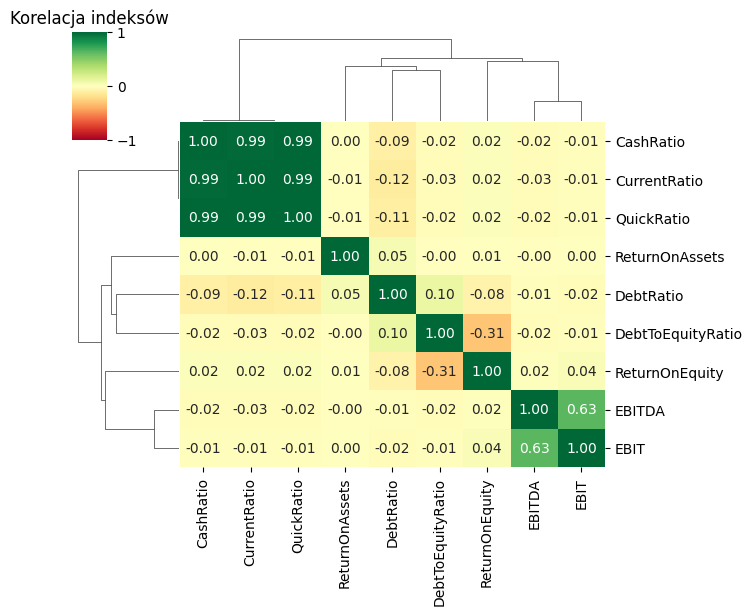

In [10]:
# Correlation indexes display
sns.clustermap(report_index.iloc[:,2:].corr(), cmap='RdYlGn', vmin=-1, vmax=1, 
               fmt='.2f', annot=True, figsize=(7, 6))
plt.title("Korelacja indeksów", loc="center")
plt.show()

In [4]:
report_index = report_index.drop(columns=["QuickRatio", "CashRatio"])

### Różnicowa metoda wzrostu/spadku

In [175]:
from sklearn.metrics import root_mean_squared_error

def differential_value(x):
    return (x[1:] - x[:-1]) / x[:-1] * 100
    
def nrmse(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mean = np.mean(y_true)
    return rmse / mean

In [207]:
from sklearn.linear_model import LinearRegression

OFFSET = 30

columns_name = ["PRE_WIG_SEC", "POST_WIG_SEC", "PRE_WIG", "POST_WIG", "PRE_WIGS", "POST_WIGS"]
mm_df = pd.DataFrame()
lr_model = LinearRegression(n_jobs=-1)


for idx, row in report_database.iterrows():
    err = []
    ticker = row["Ticker"]
    date = row["Data"]
    cmp_pre_stock_price = csp.getNHistoricalPriceBefore(ticker, date, 20, 15)
    idx_pre_stock_price = isp.getNHistoricalPriceBefore(ticker, date, 20, 15)
    wig_pre_stock_price = isp.getNHistoricalPriceBefore("WIG_POLAND", date, 20, 15)

    cmp_aft_stock_price = csp.getNHistoricalPriceAfter(ticker, date, 20, 15)
    idx_aft_stock_price = isp.getNHistoricalPriceAfter(ticker, date, 20, 15)
    wig_aft_stock_price = isp.getNHistoricalPriceAfter("WIG_POLAND", date, 20, 15)


        # Skip when data frame is empty or is not valid
    if cmp_pre_stock_price.empty or idx_pre_stock_price.empty or wig_pre_stock_price.empty:
        continue

    if cmp_aft_stock_price.empty or idx_aft_stock_price.empty or wig_aft_stock_price.empty:
        continue

    if np.unique([cmp_pre_stock_price.shape[0], idx_pre_stock_price.shape[0], wig_pre_stock_price.shape[0]]).shape[0] > 1:
        continue

    if np.unique([cmp_aft_stock_price.shape[0], idx_aft_stock_price.shape[0], wig_aft_stock_price.shape[0]]).shape[0] > 1:
        continue

    # Learn linear regression
    lr_model.fit(differential_value(idx_pre_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                 differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)))
    y_pred_pre = nrmse(differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(idx_pre_stock_price["Close"].to_numpy().reshape(-1, 1))))
    y_pred_aft = nrmse(differential_value(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(idx_aft_stock_price["Close"].to_numpy().reshape(-1, 1))))
    
    err = err + [y_pred_pre, y_pred_aft]

    lr_model.fit(differential_value(wig_pre_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                 differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)))
    y_pred_pre = nrmse(differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(wig_pre_stock_price["Close"].to_numpy().reshape(-1, 1))))
    y_pred_aft = nrmse(differential_value(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(wig_aft_stock_price["Close"].to_numpy().reshape(-1, 1))))
    
    err = err + [y_pred_pre, y_pred_aft]


    lr_model.fit(differential_value(np.array([idx_pre_stock_price["Close"].to_numpy(), wig_pre_stock_price["Close"].to_numpy()]).T), 
                 differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)))
    y_pred_pre = nrmse(differential_value(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(np.array([idx_pre_stock_price["Close"].to_numpy(), wig_pre_stock_price["Close"].to_numpy()]).T)))
    y_pred_aft = nrmse(differential_value(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1)), 
                       lr_model.predict(differential_value(np.array([idx_aft_stock_price["Close"].to_numpy(), wig_aft_stock_price["Close"].to_numpy()]).T)))
    
    err = err + [y_pred_pre, y_pred_aft]

    mm_df = pd.concat([mm_df, pd.DataFrame(columns=columns_name, 
                                           data=[err], 
                                           index=[idx])], ignore_index=False)


In [209]:
mm_df.mean()

PRE_WIG_SEC     0.028405
POST_WIG_SEC    0.190602
PRE_WIG         0.028933
POST_WIG        0.196431
PRE_WIGS        0.024174
POST_WIGS       0.206671
dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression

OFFSET = 30

columns_name = ["PRE_WIG_SEC", "POST_WIG_SEC", "PRE_WIG", "POST_WIG", "PRE_WIGS", "POST_WIGS"]
mm_df = pd.DataFrame()
lr_model = LinearRegression(n_jobs=-1)


for idx, row in report_database.iterrows():
    err = []
    ticker = row["Ticker"]
    date = row["Data"]
    cmp_pre_stock_price = csp.getNHistoricalPriceBefore(ticker, date, 20, 15)
    idx_pre_stock_price = isp.getNHistoricalPriceBefore(ticker, date, 20, 15)
    wig_pre_stock_price = isp.getNHistoricalPriceBefore("WIG_POLAND", date, 20, 15)

    cmp_aft_stock_price = csp.getNHistoricalPriceAfter(ticker, date, 20, 15)
    idx_aft_stock_price = isp.getNHistoricalPriceAfter(ticker, date, 20, 15)
    wig_aft_stock_price = isp.getNHistoricalPriceAfter("WIG_POLAND", date, 20, 15)


        # Skip when data frame is empty or is not valid
    if cmp_pre_stock_price.empty or idx_pre_stock_price.empty or wig_pre_stock_price.empty:
        continue

    if cmp_aft_stock_price.empty or idx_aft_stock_price.empty or wig_aft_stock_price.empty:
        continue

    if np.unique([cmp_pre_stock_price.shape[0], idx_pre_stock_price.shape[0], wig_pre_stock_price.shape[0]]).shape[0] > 1:
        continue

    if np.unique([cmp_aft_stock_price.shape[0], idx_aft_stock_price.shape[0], wig_aft_stock_price.shape[0]]).shape[0] > 1:
        continue

    # Learn linear regression
    lr_model.fit(idx_pre_stock_price["Close"].to_numpy().reshape(-1, 1), 
                 cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1))
    y_pred_pre = nrmse(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(idx_pre_stock_price["Close"].to_numpy().reshape(-1, 1)))
    y_pred_aft = nrmse(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(idx_aft_stock_price["Close"].to_numpy().reshape(-1, 1)))
    
    err = err + [y_pred_pre, y_pred_aft]

    lr_model.fit(wig_pre_stock_price["Close"].to_numpy().reshape(-1, 1), 
                 cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1))
    y_pred_pre = nrmse(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(wig_pre_stock_price["Close"].to_numpy().reshape(-1, 1)))
    y_pred_aft = nrmse(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(wig_aft_stock_price["Close"].to_numpy().reshape(-1, 1)))
    
    err = err + [y_pred_pre, y_pred_aft]


    lr_model.fit(np.array([idx_pre_stock_price["Close"].to_numpy(), wig_pre_stock_price["Close"].to_numpy()]).T, 
                 cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1))
    y_pred_pre = nrmse(cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(np.array([idx_pre_stock_price["Close"].to_numpy(), wig_pre_stock_price["Close"].to_numpy()]).T))
    y_pred_aft = nrmse(cmp_aft_stock_price["Close"].to_numpy().reshape(-1, 1), 
                       lr_model.predict(np.array([idx_aft_stock_price["Close"].to_numpy(), wig_aft_stock_price["Close"].to_numpy()]).T))
    
    err = err + [y_pred_pre, y_pred_aft]

    mm_df = pd.concat([mm_df, pd.DataFrame(columns=columns_name, 
                                           data=[err], 
                                           index=[idx])], ignore_index=False)


In [204]:
lr_model.fit(np.array([idx_pre_stock_price["Close"].to_numpy(), wig_pre_stock_price["Close"].to_numpy()]).T, 
                 cmp_pre_stock_price["Close"].to_numpy().reshape(-1, 1))

LinearRegression(n_jobs=-1)

In [ ]:
from sklearn.linear_model import LinearRegression

OFFSET = 30

columns_name = [f"t{i}" for i in range(-ANALYSIS_RANGE,ANALYSIS_RANGE)]
mm_df = pd.DataFrame()

lr_model = LinearRegression(n_jobs=-1)

for idx, row in report_database.iterrows():
    ticker = row["Ticker"]
    date = row["Data"]
    company_value = csp.getNHistoricalPriceBefore(ticker, date, 20, 15)
    index_value   = isp.getNHistoricalPriceBefore(ticker, date, 20, 15)

    # Skip when data frame is empty or is not valid
    if company_value.empty or index_value.empty:
        continue

    if company_value.shape[0] != index_value.shape[0]:
        continue

    company_close_value = company_value["CompanyReturn"].to_numpy()
    index_close_value = index_value["IndexReturn"].to_numpy()

    # Linear regression model 
    lr_model.fit(index_close_value[:WINDOW_SIZE].reshape(-1, 1), 
                 company_close_value[:WINDOW_SIZE].reshape(-1, 1))
    y_pred = lr_model.predict(index_close_value[:WINDOW_SIZE].reshape(-1, 1))
    score = r2_score(company_close_value[:WINDOW_SIZE].reshape(-1, 1), y_pred)

    # Skip when linear regression fit is not enough
    if score < 0.5:
        continue

    extra_component = company_close_value[-2*ANALYSIS_RANGE:] - \
        (lr_model.intercept_ + lr_model.coef_ * index_close_value[-2*ANALYSIS_RANGE:])
    
    mm_df = pd.concat([mm_df, pd.DataFrame(columns=columns_name, 
                                           data=extra_component, 
                                           index=[idx])], ignore_index=False)

In [18]:
company   = csp.getNHistoricalPriceBefore("ATR", "12-12-2022", 20, 20)["Close"].to_numpy()
wig_small = isp.getNHistoricalPriceBefore("ATR", "12-12-2022", 20, 20)["Close"].to_numpy()
wig       = isp.getNHistoricalPriceBefore("WIG_POLAND", "12-12-2022", 20, 20)["Close"].to_numpy()

In [162]:
company_a   = csp.getNHistoricalPriceAfter("ATR", "12-12-2022", 20, 20)["Close"].to_numpy()
wig_small_a = isp.getNHistoricalPriceAfter("ATR", "12-12-2022", 20, 20)["Close"].to_numpy()
wig_a       = isp.getNHistoricalPriceAfter("WIG_POLAND", "12-12-2022", 20, 20)["Close"].to_numpy()

In [170]:
company_diff_a = (company_a[1:] - company_a[:-1]) / company_a[:-1] * 100
wig_small_diff_a = (wig_small_a[1:] - wig_small_a[:-1]) / wig_small_a[:-1] * 100
wig_diff_a = (wig_a[1:] - wig_a[:-1]) / wig_a[:-1] * 100

In [171]:
company_diff = (company[1:] - company[:-1]) / company[:-1] * 100
wig_small_diff = (wig_small[1:] - wig_small[:-1]) / wig_small[:-1] * 100
wig_diff = (wig[1:] - wig[:-1]) / wig[:-1] * 100

### Próba uczenia maszynowego

In [142]:
from sklearn.metrics import r2_score

y_pred = reg.predict(np.array([wig_small_diff, wig_diff]).T)
score = r2_score(np.array([company_diff]).T, y_pred)
score

0.22212657187945894

### Szeroki horyzont obserwacji

W krótkim horyzoncie obserwacji wokół dnia publikacji sprawozdania finansowego nie zauważono istotnych statystycznie zmian.
Z tego powodu postanowiono rozszerzyć horyzont obserwacji na dłuższy okres.

Założenia:
   

KeyboardInterrupt: 

In [12]:
from enum import Enum
import yfinance as yf 

class StockPricesPreprocessing:
    class PriceType(Enum):
        OPEN = "Open"
        CLOSE = "Close"
        VOLUME = "Volume"

    @staticmethod
    def mean_price(df : pd.DataFrame, type : PriceType = PriceType.CLOSE ) -> float:
        return df[type.value].mean()

In [5]:
offset = 60
period = 15

sp = CompanyPriceScraper()
long_period = pd.DataFrame()
for index, row in report_database.iterrows():
    ticker, date = row["Ticker"], row["Data"]

    before = sp.getHistoricalBefore(ticker, date, offset, period)
    after  = sp.getHistoricalAfter(ticker, date, offset, period) 
    if before.empty or after.empty:
        continue

    before_mean = StockPricesPreprocessing.mean_price(before)
    after_mean  = StockPricesPreprocessing.mean_price(after)

    diff = (after_mean - before_mean) / before_mean * 100
    long_period = pd.concat([long_period, pd.DataFrame(columns=["Differential"], data=[diff], index=[index])], ignore_index=False)


TypeError: Can't instantiate abstract class CompanyPriceScraper without an implementation for abstract method '_PriceScraper__downloadHistoricalStockPrice'

In [649]:
merged = pd.concat([report_index, yearly_period], axis=1, join="inner")

In [650]:
from sklearn.preprocessing import StandardScaler
X = merged.drop(columns=['Differential']).values
y = merged['Differential'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [651]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import Huber

model = Sequential()

# Warstwa wejściowa
model.add(Input(shape = (X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout 30%

# Warstwa ukryta 1
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout 30%

# Warstwa ukryta 2
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))  # Dropout 20%

# Warstwa wyjściowa
model.add(Dense(1))

model.compile(optimizer='adam', loss="mean_squared_error")

In [652]:
model.fit(X_train, y_train, epochs=150, batch_size=5)

Epoch 1/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 16521.3906
Epoch 2/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5186.2666
Epoch 3/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6179.3833
Epoch 4/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5006.2026
Epoch 5/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6951.4814
Epoch 6/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4320.4312
Epoch 7/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5359.8354
Epoch 8/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5209.3296
Epoch 9/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4431.9014
Epoch 10/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5040.2031
Epoch 11/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4166.6387
Epoch 12/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6305.0469
Epoch 13/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5990.0454
Epoch 14/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5610.7446


In [653]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1882.4191 
Test Loss: 2109.204833984375


In [654]:
predictions = model.predict(X_test)
print("Predykcje:", predictions)
np.min(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predykcje: [[112.65458 ]
 [120.659454]
 [114.98869 ]
 [112.86482 ]
 [108.33807 ]
 [110.48773 ]
 [ 89.63398 ]
 [111.22241 ]
 [ 69.42933 ]
 [ 76.367226]
 [109.44513 ]
 [111.08276 ]
 [107.705765]
 [105.43111 ]
 [113.298706]
 [100.780876]
 [110.031044]
 [111.26082 ]
 [104.54201 ]
 [111.36571 ]
 [111.14564 ]
 [108.35095 ]
 [107.799515]
 [111.316055]
 [107.76275 ]
 [111.890366]
 [101.57205 ]
 [100.54594 ]
 [111.346   ]
 [104.9263  ]
 [107.52788 ]
 [106.81685 ]
 [114.688126]
 [112.92233 ]
 [101.460846]
 [109.26016 ]
 [107.8316  ]
 [ 92.521965]
 [106.04677 ]
 [103.51845 ]
 [110.63823 ]
 [ 98.87317 ]
 [101.533356]
 [101.06228 ]
 [106.793655]
 [ 87.93994 ]
 [100.010956]
 [111.14479 ]
 [ 98.68179 ]
 [111.555885]
 [101.39552 ]
 [119.51144 ]
 [105.49313 ]
 [115.54434 ]
 [125.522514]
 [110.55063 ]
 [104.66255 ]
 [111.53861 ]
 [105.114746]
 [110.0643  ]
 [108.363846]
 [104.70008 ]
 [110.19314 ]
 [104.84914 ]
 [109.17534 ]
 [105.03664 ]
 [111.8625  ]
 [106.08052 

22.550747

### Roczne różnice

In [663]:
sp = CompanyPriceScraper()
ip = IndexPriceScraper()
yearly_period = pd.DataFrame()
for index, row in report_database.iterrows():
    ticker, date = row["Ticker"], int(row["Data"][:4])
    
    # Company statistic
    company_before = sp.getYearlyHistorical(ticker, np.datetime64(f"{date-1}"))
    company_after  = sp.getYearlyHistorical(ticker, np.datetime64(f"{date}")) 
    if company_before.empty or company_after.empty:
        continue

    company_before_mean = StockPricesPreprocessing.mean_price(company_before)
    company_after_mean  = StockPricesPreprocessing.mean_price(company_after)

    company_diff = (company_after_mean - company_before_mean) / company_before_mean * 100
    
    # Index statistic
    index_before = ip.getYearlyHistorical(ticker, np.datetime64(f"{date-1}"))
    index_after  = sp.getYearlyHistorical(ticker, np.datetime64(f"{date}")) 
    if index_before.empty or index_after.empty:
        continue

    index_before_mean = StockPricesPreprocessing.mean_price(index_before)
    index_after_mean  = StockPricesPreprocessing.mean_price(index_after)

    index_diff = (index_after_mean - index_before_mean) / index_before_mean * 100
    
    
    yearly_period = pd.concat([yearly_period, pd.DataFrame(columns=["CompanyDiff", "IndexDiff"], 
                                                           data=[[company_diff, index_diff]], 
                                                           index=[index])], ignore_index=False)